# The Iris Dataset with Eager Execution



## Setup program

### Install the latest version of TensorFlow



In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.9.0rc1)
Requirement not upgraded as not directly required: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (1.1.0)
Requirement not upgraded as not directly required: astor>=0.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.6.2)
Requirement not upgraded as not directly required: protobuf>=3.4.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (3.6.0)
Requirement not upgraded as not directly required: setuptools<=39.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (39.1.0)
Requirement not upgraded as not directly required: tensorboard<1.10.0,>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (1.9.0)
Requirement not upgraded as not directly required: wheel>=0.26 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.31.1)
Requirement not upgraded as not directly required: grpcio>=1.8.6 in /usr/local/lib/p

### Configure imports and eager execution



In [2]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

tf.logging.set_verbosity(tf.logging.ERROR)

TensorFlow version: 1.9.0-rc1
Eager execution: True


## Import and parse the training dataset


### Download the dataset



In [3]:
training_file_url = "http://download.tensorflow.org/data/iris_training.csv"
training_file_path = tf.keras.utils.get_file(
    fname=os.path.basename(training_file_url),
    origin=training_file_url
)

print("Location of the training data file: {}".format(training_file_path))

Location of the training data file: /content/.keras/datasets/iris_training.csv


### Inspect the data



In [4]:
!head -n5 {training_file_path}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


### Parse the dataset


In [0]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 4 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

### Create the training tf.data.Dataset



In [6]:
training_dataset = tf.data.TextLineDataset(training_file_path).skip(1).map(parse_csv).shuffle(buffer_size=1000).batch(32)

# View a single example entry from a batch
features, label = iter(training_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([6.5 3.2 5.1 2. ], shape=(4,), dtype=float32)
example label: tf.Tensor(2, shape=(), dtype=int32)


## Select the type of model



### Create a model using Keras



In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
])

## Train the model



### Define the loss and gradient function



In [0]:
def loss_fn(model, features, y):
    y_ = model(features)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def gradients_fn(model, features, targets):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, features, targets)
    return tape.gradient(loss, model.variables)

### Create an optimizer



In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

### Training loop



In [10]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
training_loss_results = []
training_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_mean = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  for x, y in training_dataset:
    gradients = gradients_fn(model, x, y)

    optimizer.apply_gradients(
        zip(gradients, model.variables),
        global_step=tf.train.get_or_create_global_step()
    )

    epoch_loss_mean(loss_fn(model, x, y))
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
  
  training_loss_results.append(epoch_loss_mean.result())
  training_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 20 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_mean.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.531, Accuracy: 29.167%
Epoch 020: Loss: 0.582, Accuracy: 95.000%
Epoch 040: Loss: 0.382, Accuracy: 91.667%
Epoch 060: Loss: 0.302, Accuracy: 95.000%
Epoch 080: Loss: 0.245, Accuracy: 96.667%
Epoch 100: Loss: 0.199, Accuracy: 97.500%
Epoch 120: Loss: 0.173, Accuracy: 98.333%
Epoch 140: Loss: 0.149, Accuracy: 97.500%
Epoch 160: Loss: 0.139, Accuracy: 97.500%
Epoch 180: Loss: 0.123, Accuracy: 97.500%
Epoch 200: Loss: 0.109, Accuracy: 97.500%


### Visualize the loss function over time

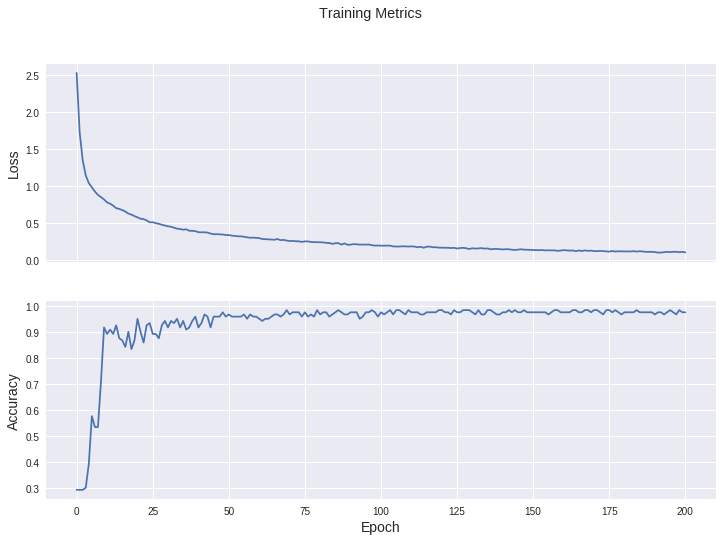

In [11]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(training_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(training_accuracy_results)

plt.show()

## Evaluate the model's effectiveness



### Setup the test dataset



In [0]:
test_file_url = "http://download.tensorflow.org/data/iris_test.csv"
test_file_path = tf.keras.utils.get_file(
    fname=os.path.basename(test_file_url),
    origin=test_file_url
)

test_dataset = tf.data.TextLineDataset(test_file_path).skip(1).map(parse_csv).shuffle(1000).batch(32)

### Evaluate the model on the test dataset



In [13]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
    prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


## Use the trained model to make predictions


In [14]:
class_names = ["Iris Setosa", "Iris Versicolor", "Iris Virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  class_name = class_names[class_idx]
  print("Example {} prediction: {}".format(i, class_name))

Example 0 prediction: Iris Setosa
Example 1 prediction: Iris Versicolor
Example 2 prediction: Iris Virginica
